In [29]:
%pip install opencv-python
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
# connected_components
import cv2
import numpy as np

def connected_components(image_input, min_area=10):
    """
    Given an image of a handwritten formula, extract and return individual symbol images.
    
    Args:
        image_input: str (file path) or np.ndarray (image loaded already)
        min_area: minimum area to filter out small noise
    
    Returns:
        List of np.ndarray: each is a cropped image of a symbol
    """
    if isinstance(image_input, str):
        img = cv2.imread(image_input, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_input.copy()

    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary)

    symbols = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area >= min_area:
            symbol_img = binary[y:y+h, x:x+w]
            symbols.append((x, symbol_img))

    symbols.sort(key=lambda item: item[0])

    return [img for (_, img) in symbols]


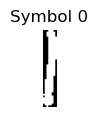

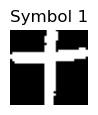

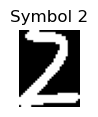

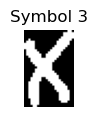

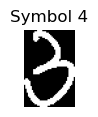

In [31]:
import matplotlib.pyplot as plt

symbols = connected_components("test.jpg")

for i, symbol_img in enumerate(symbols):
    plt.figure(figsize=(1, 1))
    plt.imshow(symbol_img, cmap='gray')
    plt.axis('off')
    plt.title(f"Symbol {i}")
    plt.show()

In [34]:
!pip uninstall -y runipy
!pip uninstall -y pytest-ipynb
!pytest --cov=connected_components test_components.py --cov-report=html
!pytest --cov=connected_components test_components.py --cov-report=term
import webbrowser
webbrowser.open("htmlcov/index.html")

Found existing installation: runipy 0.1.5
Uninstalling runipy-0.1.5:
  Successfully uninstalled runipy-0.1.5
Found existing installation: pytest-ipynb 1.1.1
Uninstalling pytest-ipynb-1.1.1:
  Successfully uninstalled pytest-ipynb-1.1.1
============================= test session starts ==============================
platform darwin -- Python 3.11.8, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/ravanryj/Desktop/team-00-project/Hezi_Jiang_423
plugins: anyio-4.3.0, cov-6.1.1
collected 2 items                                                              

test_components.py ..                                                    [100%]

================================ tests coverage ================================
_______________ coverage: platform darwin, python 3.11.8-final-0 _______________

Coverage HTML written to dir htmlcov
============================== 2 passed in 0.21s ===============================
============================= test session starts ==============================
pl

True

In [35]:
%pip install torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [36]:
# Faster R-CNN
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import numpy as np

def detect_symbols_frcnn(image_input, confidence_threshold=0.5):
    """
    Detect symbols in a handwritten formula using Faster R-CNN.

    Args:
        image_input: file path or a numpy array or PIL.Image
        confidence_threshold: filter out low confidence boxes

    Returns:
        List of cropped symbol images (as numpy arrays)
    """
    if isinstance(image_input, str):
        image = Image.open(image_input).convert("RGB")
    elif isinstance(image_input, np.ndarray):
        image = Image.fromarray(image_input).convert("RGB")
    elif isinstance(image_input, Image.Image):
        image = image_input.convert("RGB")
    else:
        raise ValueError("Unsupported image input type")

    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    img_tensor = transform(image)

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    with torch.no_grad():
        predictions = model([img_tensor])[0]

    boxes = predictions['boxes']
    scores = predictions['scores']

    cropped = []
    for box, score in zip(boxes, scores):
        if score >= confidence_threshold:
            xmin, ymin, xmax, ymax = box.int().tolist()
            cropped_img = img_tensor[:, ymin:ymax, xmin:xmax].mul(255).byte().permute(1, 2, 0).numpy()
            cropped.append(cropped_img)

    return cropped


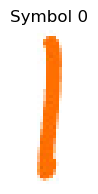

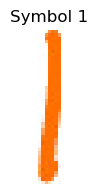

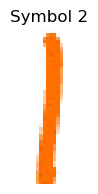

In [42]:
import matplotlib.pyplot as plt
import cv2 

symbols = detect_symbols_frcnn("test.jpg", confidence_threshold=0.1)

for i, s in enumerate(symbols):
    plt.figure(figsize=(2, 2))
    if len(s.shape) == 3 and s.shape[2] == 3:
        s = cv2.cvtColor(s, cv2.COLOR_BGR2RGB)
    plt.imshow(s, cmap='gray' if len(s.shape) == 2 else None)
    plt.title(f"Symbol {i}")
    plt.axis('off')
    plt.show()


In [45]:
!pytest --cov=detect_symbols test_detect_symbols.py --cov-report=term --cov-report=html
import webbrowser
webbrowser.open('htmlcov/index.html')

============================= test session starts ==============================
platform darwin -- Python 3.11.8, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/ravanryj/Desktop/team-00-project/Hezi_Jiang_423
plugins: anyio-4.3.0, cov-6.1.1
collected 3 items                                                              

test_detect_symbols.py ...                                               [100%]

=============================== warnings summary ===============================
test_detect_symbols.py::test_detect_symbols_empty_image
test_detect_symbols.py::test_detect_symbols_real_image
  /Users/ravanryj/miniconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

test_detect_symbols.py::test_detect_symbols_empty_image
test_detect_symbols.py::test_detect_symbols_real_image
  /Users/ravanryj/miniconda3/envs/torch/lib/p

True

In [46]:
%pip install torch torchvision matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# U-Net
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.enc1 = nn.Sequential(CBR(in_channels, 64), CBR(64, 64))
        self.enc2 = nn.Sequential(CBR(64, 128), CBR(128, 128))
        self.pool = nn.MaxPool2d(2, 2)
        self.dec1 = nn.Sequential(CBR(128, 64), CBR(64, 64))
        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        d1 = F.interpolate(e2, scale_factor=2)
        d1 = self.dec1(d1)
        out = self.final(d1)
        return torch.sigmoid(out)
    
import cv2
import numpy as np
from torchvision import transforms

def segment_symbols_unet(image_input, model, threshold=0.5, min_area=10):
    """
    Use U-Net to segment and extract individual symbol images.
    """
    if isinstance(image_input, str):
        image = cv2.imread(image_input, cv2.IMREAD_GRAYSCALE)
    elif isinstance(image_input, np.ndarray):
        image = image_input
    else:
        raise ValueError("Unsupported input type")

    h, w = image.shape
    tensor = transforms.ToTensor()(image).unsqueeze(0)

    with torch.no_grad():
        pred_mask = model(tensor)[0, 0].numpy()

    binary_mask = (pred_mask > threshold).astype(np.uint8) * 255

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask)

    symbols = []
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        if area >= min_area:
            symbols.append(image[y:y+h, x:x+w])

    return symbols



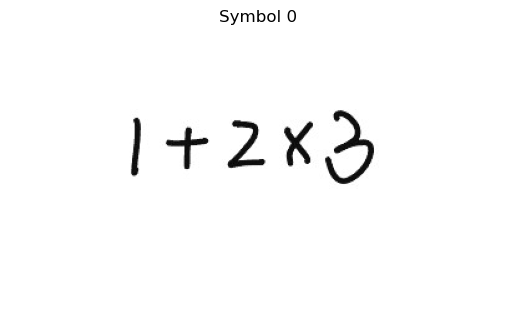

In [48]:
model = UNet()

symbols = segment_symbols_unet("test.jpg", model)

import matplotlib.pyplot as plt
for i, sym in enumerate(symbols):
    plt.imshow(sym, cmap='gray')
    plt.title(f"Symbol {i}")
    plt.axis('off')
    plt.show()

In [49]:
!pytest --cov=unet_model test_unet_model.py --cov-report=term --cov-report=html
import webbrowser
webbrowser.open('htmlcov/index.html')

============================= test session starts ==============================
platform darwin -- Python 3.11.8, pytest-8.3.5, pluggy-1.5.0
rootdir: /Users/ravanryj/Desktop/team-00-project/Hezi_Jiang_423
plugins: anyio-4.3.0, cov-6.1.1
collected 2 items                                                              

test_unet_model.py ..                                                    [100%]

================================ tests coverage ================================
_______________ coverage: platform darwin, python 3.11.8-final-0 _______________

Name            Stmts   Miss  Cover
-----------------------------------
unet_model.py      41      1    98%
-----------------------------------
TOTAL              41      1    98%
Coverage HTML written to dir htmlcov
============================== 2 passed in 1.98s ===============================


True